# To my understanding Tree algorithms do not need normalization
I am doing it anyway, to see if it changes the performance at all

In [1]:
import pandas as pd
import numpy as np

In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
from sklearn.preprocessing import OneHotEncoder

# Loading Data 

In [4]:
train_data = pd.read_csv('./train.csv')

In [5]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# Impute NANs 

In [6]:
for col in ["Cabin", "Ticket", "Embarked"]:
    train_data[col].fillna("None", inplace=True)

# Generate Features 

In [7]:
def cabincount(x):
    if x == "None":
        return (0)
    else:
        return (x.count(" ")+1)        

In [8]:
train_data["Deck"] = train_data["Cabin"].map( lambda x:x[0])
train_data["Cabin_count"] = train_data["Cabin"].map( cabincount )


# Dropping Features 

In [9]:
train_data.drop(["Name", "PassengerId","Ticket","Cabin"], axis=1, inplace=True)

# One Hot Encoding 

In [10]:
enc_list = ["Sex","Deck","Embarked"]
enc = {enc_list_item : OneHotEncoder().fit(train_data[enc_list_item].values.reshape(-1,1)) for enc_list_item in enc_list}
A = None
Encoded_features = []
for key in enc:
    B = enc[key].transform(train_data[key].values.reshape(-1,1))
    if A is None:
        A = B.todense().copy()
    else:
        A = np.hstack((A,B.todense()))
    Encoded_features += [f"{key}_{feature}" for cat in enc[key].categories_ for feature in cat]
# Drop Sex_male
di = Encoded_features.index("Sex_male")
A = np.delete(A,[di],axis=1)
Encoded_features = [x for x in Encoded_features if x != "Sex_male"]
A = np.hstack((train_data.drop(enc_list+["Survived"], axis=1).values, A))

In [11]:
All_features = train_data.drop(enc_list+["Survived"], axis=1).columns.tolist() + Encoded_features

# Normalizing Data 

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(copy=False)
A[0:6] = scaler.fit_transform(A[0:6])

# Splitting Data 

In [13]:
X = A
Y = train_data['Survived'].values

seed = 4711
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=test_size, random_state=seed)

# Fit XGBoost 

In [14]:
model = XGBClassifier(max_depth=3, n_estimators=100, random_state=seed, seed=seed, nthread=4)
model.fit(X_train, y_train);

# Visualize Tree 

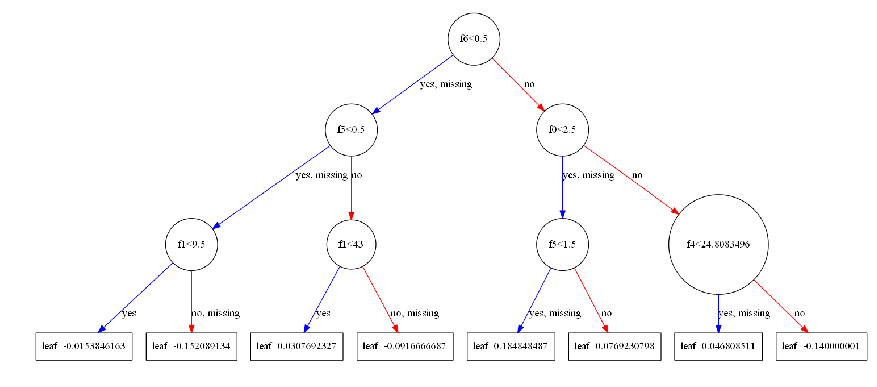

In [15]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(15,20))

plot_tree(model, ax=ax)
plt.show()

In [17]:
for i in [6,5,0,1,4]:
    print(i,All_features[i])

6 Sex_female
5 Cabin_count
0 Pclass
1 Age
4 Fare


In [18]:
pd.DataFrame(
    model.feature_importances_,
    All_features,
    columns=["Feature_Importance"]
    ).sort_values(
    by="Feature_Importance",
    ascending=False
)

Feature_Importance
Fare                     0.353357
Age                      0.275618
Sex_female               0.074205
SibSp                    0.063604
Pclass                   0.060071
Cabin_count              0.056537
Embarked_S               0.035336
Deck_E                   0.019435
Deck_C                   0.015901
Parch                    0.014134
Deck_D                   0.010601
Deck_A                   0.007067
Embarked_C               0.007067
Embarked_Q               0.005300
Deck_B                   0.001767
Deck_F                   0.000000
Deck_G                   0.000000
Deck_N                   0.000000
Deck_T                   0.000000
Embarked_None            0.000000

# Making Prediction test set 

In [19]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.56%
